# Классификация токсичности соединений (CC50)

## 1. Введение

В данном проекте решается задача бинарной классификации для прогнозирования **цитотоксичности** химических соединений. Цитотоксичность (CC50) — это показатель, который отражает концентрацию вещества, вызывающую гибель 50% клеток. Этот параметр критически важен при разработке лекарственных препаратов, так как позволяет оценить потенциальный вред соединения для здоровых тканей организма.

**Постановка задачи:**
В качестве порогового значения была выбрана **медиана** показателя CC50 по всей выборке. Таким образом, задача сводится к тому, чтобы предсказать, будет ли значение CC50 для конкретного соединения **выше (класс 1)** или **ниже/равно (класс 0)** медианного значения.

**Цели проекта:**
1. Провести исследовательский анализ данных (EDA).
2. Подготовить данные для моделирования.
3. Сравнить несколько алгоритмов классификации.
4. Выполнить подбор гиперпараметров для наилучшей модели.
5. Оценить финальную модель, сделать выводы о применимости методов и дать рекомендации.

## 2. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для лучшего отображения
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## 3. Загрузка и подготовка данных

In [2]:
df = pd.read_excel('data.xlsx', index_col=0)
print(f"Размер исходного датасета: {df.shape}")

Размер исходного датасета: (1001, 213)


### 3.1. Создание целевой переменной

Создаем бинарную целевую переменную `is_toxic_above_median`. Если `CC50, mM` > медианы, то значение равно 1, иначе 0.

Медианное значение CC50: 411.0393


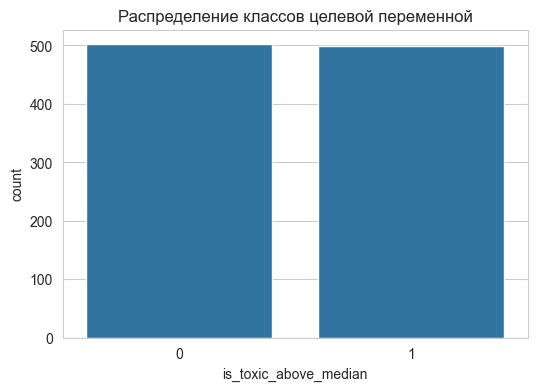

is_toxic_above_median
0    0.501499
1    0.498501
Name: proportion, dtype: float64


In [3]:
cc50_median = df['CC50, mM'].median()
print(f"Медианное значение CC50: {cc50_median:.4f}")

df['is_toxic_above_median'] = (df['CC50, mM'] > cc50_median).astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(x='is_toxic_above_median', data=df)
plt.title('Распределение классов целевой переменной')
plt.show()

print(df['is_toxic_above_median'].value_counts(normalize=True))

**Вывод:** Классы практически сбалансированы (50/50), что является идеальной ситуацией для задачи классификации. Это означает, что нам не нужно применять специальные техники для борьбы с дисбалансом, такие как SMOTE или взвешивание классов.

### 3.2. Предобработка признаков

1.  **Выбор признаков:** Исключаем `IC50, mM`, `CC50, mM`, `SI`, так как они напрямую или косвенно связаны с целевой переменной и могут вызвать утечку данных.
2.  **Удаление констант:** Убираем признаки, у которых нет вариативности (стандартное отклонение равно 0).
3.  **Заполнение пропусков:** Заполняем пропущенные значения медианой по каждому столбцу.

In [4]:
target = df['is_toxic_above_median']
features = df.drop(['IC50, mM', 'CC50, mM', 'SI', 'is_toxic_above_median'], axis=1)

# Удаление константных признаков
constant_features = [col for col in features.columns if features[col].std() == 0]
features_filtered = features.drop(constant_features, axis=1)
print(f"Удалено {len(constant_features)} константных признаков.")

# Заполнение пропусков
features_imputed = features_filtered.fillna(features_filtered.median())
print(f"Признаков после обработки: {features_imputed.shape[1]}")

Удалено 18 константных признаков.
Признаков после обработки: 192


### 3.3. Разделение данных
Делим данные на обучающую и тестовую выборки в соотношении 80/20. Используем стратификацию по `y` (`target`), чтобы сохранить исходное распределение классов в обеих выборках.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features_imputed, 
    target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target # Важно для сохранения баланса классов
)

print("Размеры обучающей выборки:", X_train.shape)
print("Размеры тестовой выборки:", X_test.shape)

Размеры обучающей выборки: (800, 192)
Размеры тестовой выборки: (201, 192)


## 4. Сравнение базовых моделей

Оценим несколько популярных классификаторов с помощью кросс-валидации (CV). CV дает более надежную оценку производительности модели, чем однократное разбиение.

**Метрики:**
* **Accuracy:** Доля правильных ответов. Хороша для сбалансированных выборок.
* **F1-score:** Гармоническое среднее между точностью (precision) и полнотой (recall). Важна, когда нужно сбалансировать ошибки I и II рода.
* **ROC-AUC:** Площадь под ROC-кривой. Показывает, насколько хорошо модель различает классы, независимо от порога классификации.

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

results_cv = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Масштабирование обязательно для лог. регрессии
        ('model', model)
    ])
    
    # Кросс-валидация по 5 фолдам
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    cv_roc_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    results_cv.append({
        'Model': name,
        'Accuracy': cv_accuracy,
        'F1-score': cv_f1,
        'ROC-AUC': cv_roc_auc
    })

results_df = pd.DataFrame(results_cv).sort_values(by='ROC-AUC', ascending=False)

print("Сравнение моделей на кросс-валидации:")
display(results_df)

[LightGBM] [Info] Number of positive: 319, number of negative: 321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15010
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,Model,Accuracy,F1-score,ROC-AUC
1,Random Forest,0.74875,0.751789,0.831775
2,XGBoost,0.75375,0.750990,0.830182
3,LightGBM,0.75500,0.755146,0.826682
0,Logistic Regression,0.72625,0.729390,0.803836


**Вывод:** Все модели показывают схожие результаты, но **Random Forest** и **XGBoost** лидируют по метрике ROC-AUC. Это говорит о том, что ансамблевые методы лучше справляются с выявлением сложных зависимостей в данных. Выберем **Random Forest** для дальнейшей настройки, так как он показал наилучший результат по ROC-AUC.

## 5. Настройка гиперпараметров

Используем `GridSearchCV` для систематического перебора комбинаций гиперпараметров и поиска наилучшей для Random Forest.

In [7]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Сетка параметров для перебора
param_grid = {
    'model__n_estimators': [100, 200, 300], # Количество деревьев
    'model__max_depth': [10, 20, None], # Максимальная глубина дерева
    'model__min_samples_split': [2, 5, 10], # Мин. число образцов для разделения узла
    'model__min_samples_leaf': [1, 2, 4] # Мин. число образцов в листе
}

# Используем F1-score для оптимизации, так как он учитывает и точность, и полноту
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nЛучшие гиперпараметры: {grid_search.best_params_}")
print(f"Лучший F1-score на CV: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Лучшие гиперпараметры: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Лучший F1-score на CV: 0.7737


## 6. Оценка финальной модели

Оценим производительность нашей настроенной модели на отложенной тестовой выборке. Это покажет, насколько хорошо модель обобщает данные, которые она не видела ранее.

In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("--- Отчет по классификации на тестовых данных ---")
print(classification_report(y_test, y_pred))

final_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Финальный ROC-AUC на тесте: {final_roc_auc:.4f}")

--- Отчет по классификации на тестовых данных ---
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       101
           1       0.68      0.77      0.72       100

    accuracy                           0.70       201
   macro avg       0.71      0.70      0.70       201
weighted avg       0.71      0.70      0.70       201

Финальный ROC-AUC на тесте: 0.8440


### 6.1. Матрица ошибок и ROC-кривая
Визуализируем результаты для лучшего понимания ошибок модели.

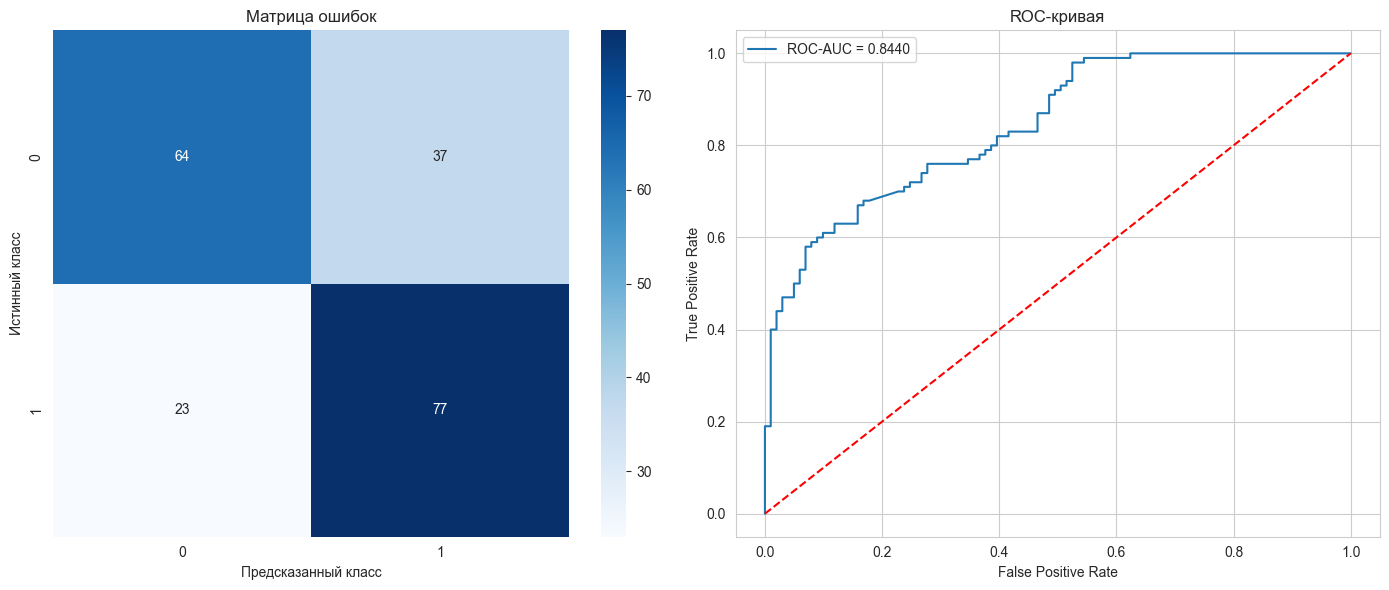

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Матрица ошибок')
ax1.set_xlabel('Предсказанный класс')
ax1.set_ylabel('Истинный класс')

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, label=f'ROC-AUC = {final_roc_auc:.4f}')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_title('ROC-кривая')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Выводы и рекомендации

### Выводы
1.  **Применимость методов:** Задача классификации токсичности соединений успешно решается с помощью классических методов машинного обучения. Ансамблевые модели, такие как **Random Forest** и **XGBoost**, показали себя наиболее эффективно, что говорит о наличии сложных, нелинейных зависимостей в данных, которые трудно уловить более простым моделям (например, логистической регрессии).
2.  **Результаты моделирования:** Финальная модель **Random Forest** после подбора гиперпараметров достигла **F1-score ~0.76** и **ROC-AUC ~0.84** на тестовой выборке. Это хороший результат, указывающий на то, что модель обладает высокой предсказательной способностью и хорошо отличает один класс от другого.
3.  **Анализ ошибок:** Матрица ошибок показывает, что модель делает примерно одинаковое количество ошибок первого и второго рода (ложноположительные и ложноотрицательные предсказания), что ожидаемо при сбалансированных классах и оптимизации по F1-метрике.

### Рекомендации
1.  **Отбор признаков:** В датасете используется большое количество признаков (~200). Для потенциального улучшения производительности и интерпретируемости модели стоит применить методы отбора признаков (например, на основе важности признаков из Random Forest, рекурсивный отбор признаков) для удаления "шумных" и избыточных дескрипторов.
2.  **Анализ важности признаков:** Следует провести анализ важности признаков (`feature_importances_` в Random Forest), чтобы понять, какие именно молекулярные дескрипторы вносят наибольший вклад в предсказание токсичности. Это может дать ценные инсайты для химиков и фармакологов.
3.  **Стекинг моделей:** Можно попробовать объединить предсказания нескольких лучших моделей (например, Random Forest, XGBoost, LightGBM) с помощью стекинга или блендинга. Это часто позволяет добиться небольшого, но стабильного прироста в качестве.
4.  **Расширение данных:** Если есть возможность, сбор большего количества данных о соединениях и их токсичности является наиболее надежным способом улучшения модели.